In [35]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron

In [33]:
from sklearn.model_selection import train_test_split
df=pd.read_csv("train.csv")
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="Survived"), df["Survived"], test_size = 0.33)

X_train["CabinNull?"] = X_train.Cabin.isnull()
X_test["CabinNull?"] = X_test.Cabin.isnull()
X_train["Total_Fam"] = X_train.Parch + X_train.SibSp
X_test["Total_Fam"] = X_test.Parch + X_test.SibSp
X_train['Age_bin'] = pd.cut(X_train['Age'], bins=[0,18,65,np.percentile(X_train.Age,100)], labels=["Youth","Adult", "Elderly"])
X_test['Age_bin'] = pd.cut(X_test['Age'], bins=[0,18,65,np.percentile(X_test.Age,100)], labels=["Youth","Adult", "Elderly"])


#Drop the unique columns that won't help our model. Both in the test and train datasets
X_train.drop(columns = ["Name","Ticket", "PassengerId","Cabin","Age"], inplace = True)
X_test.drop(columns = ["Name","Ticket", "PassengerId","Cabin","Age"], inplace = True)

#Impute the numerical variables with mean
X_train["Fare"] = X_train["Fare"].replace(np.NaN, X_train["Fare"].mean())
X_test["Fare"] = X_test["Fare"].replace(np.NaN, X_train["Fare"].mean())

#Binning - Fare
X_train['Fare_bin'] = pd.cut(X_train['Fare'], bins=[np.percentile(X_train.Fare,0),np.percentile(X_train.Fare,25),
                                                    np.percentile(X_train.Fare,50),
                                                    np.percentile(X_train.Fare,75),
                                                    np.percentile(X_train.Fare,100)], labels=["Lowest","Low-to-Mid", "Mid", "High"])
X_test['Fare_bin'] = pd.cut(X_test['Fare'], bins=[np.percentile(X_train.Fare,0),np.percentile(X_train.Fare,25),
                                                   np.percentile(X_train.Fare,50),
                                                   np.percentile(X_train.Fare,75),
                                                   np.percentile(X_train.Fare,100)], labels=["Lowest", "Low-to-Mid", "Mid", "High"])


#Change Passenger class to a string variable instead of numerical
X_train.Pclass = X_train.Pclass.astype(str)
X_test.Pclass = X_test.Pclass.astype(str)

#Impute the Categorical variables
#X_train.Cabin = X_train.Cabin.fillna(X_train['Cabin'].value_counts().index[0])
#X_test.Cabin = X_train.Cabin.fillna(X_train['Cabin'].value_counts().index[0])

X_train.Embarked = X_train.Embarked.fillna(X_train['Embarked'].value_counts().index[0])
X_test.Embarked = X_test.Embarked.fillna(X_train['Embarked'].value_counts().index[0])

X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)

In [34]:
from sklearn.model_selection import ShuffleSplit,cross_val_score
shuffle_split=ShuffleSplit(test_size=0.3,n_splits=10000)
scores=cross_val_score(model,X_train,y_train,cv=shuffle_split)
print("cross Validation scores:n {}".format(scores))
print("Average Cross Validation score :{}".format(scores.mean()))

cross Validation scores:n [0.77094972 0.76536313 0.77094972 ... 0.74860335 0.77653631 0.74301676]
Average Cross Validation score :0.7803687150837988


# Feature Selection
## Recursive Feature Elimination
It works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

In [24]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
rfe = RFECV(estimator=DecisionTreeClassifier())
rfe = rfe.fit(X_train, y_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False False  True False  True False  True  True False False False False
 False False False]
[ 5  6  1  2  1  8  1  1  9  4  3 10  7 11 12]


In [25]:
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 5.000
Column: 1, Selected False, Rank: 6.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected False, Rank: 2.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 8.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 9.000
Column: 9, Selected False, Rank: 4.000
Column: 10, Selected False, Rank: 3.000
Column: 11, Selected False, Rank: 10.000
Column: 12, Selected False, Rank: 7.000
Column: 13, Selected False, Rank: 11.000
Column: 14, Selected False, Rank: 12.000


In [26]:
X_train = pd.DataFrame(rfe.fit_transform(X_train,y_train), columns = X_train.loc[:,list(rfe.support_)].columns)

In [27]:
X_test = pd.DataFrame(rfe.transform(X_test), columns = X_test.loc[:,list(rfe.support_)].columns)

In [28]:
model = DecisionTreeClassifier()
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [29]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8338983050847457

In [30]:
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8305084745762712

In [31]:
from sklearn.model_selection import ShuffleSplit,cross_val_score
shuffle_split=ShuffleSplit(test_size=0.3,n_splits=10000)
scores=cross_val_score(model,X_train,y_train,cv=shuffle_split)
print("cross Validation scores:n {}".format(scores))
print("Average Cross Validation score :{}".format(scores.mean()))

cross Validation scores:n [0.77653631 0.73743017 0.73743017 ... 0.83240223 0.81005587 0.76536313]
Average Cross Validation score :0.7752234636871508


## Feature Importance
Methods that use ensembles of decision trees (like Random Forest or Extra Trees) can also compute the relative importance of each attribute. These importance values can be used to inform a feature selection process.

In [3]:
from sklearn.model_selection import train_test_split
df=pd.read_csv("train.csv")
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="Survived"), df["Survived"], test_size = 0.33)

X_train["CabinNull?"] = X_train.Cabin.isnull()
X_test["CabinNull?"] = X_test.Cabin.isnull()
X_train["Total_Fam"] = X_train.Parch + X_train.SibSp
X_test["Total_Fam"] = X_test.Parch + X_test.SibSp
X_train['Age_bin'] = pd.cut(X_train['Age'], bins=[0,18,65,np.percentile(X_train.Age,100)], labels=["Youth","Adult", "Elderly"])
X_test['Age_bin'] = pd.cut(X_test['Age'], bins=[0,18,65,np.percentile(X_test.Age,100)], labels=["Youth","Adult", "Elderly"])


#Drop the unique columns that won't help our model. Both in the test and train datasets
X_train.drop(columns = ["Name","Ticket", "PassengerId","Cabin","Age"], inplace = True)
X_test.drop(columns = ["Name","Ticket", "PassengerId","Cabin","Age"], inplace = True)

#Impute the numerical variables with mean
X_train["Fare"] = X_train["Fare"].replace(np.NaN, X_train["Fare"].mean())
X_test["Fare"] = X_test["Fare"].replace(np.NaN, X_train["Fare"].mean())

#Binning - Fare
X_train['Fare_bin'] = pd.cut(X_train['Fare'], bins=[np.percentile(X_train.Fare,0),np.percentile(X_train.Fare,25),
                                                    np.percentile(X_train.Fare,50),
                                                    np.percentile(X_train.Fare,75),
                                                    np.percentile(X_train.Fare,100)], labels=["Lowest","Low-to-Mid", "Mid", "High"])
X_test['Fare_bin'] = pd.cut(X_test['Fare'], bins=[np.percentile(X_train.Fare,0),np.percentile(X_train.Fare,25),
                                                   np.percentile(X_train.Fare,50),
                                                   np.percentile(X_train.Fare,75),
                                                   np.percentile(X_train.Fare,100)], labels=["Lowest", "Low-to-Mid", "Mid", "High"])


#Change Passenger class to a string variable instead of numerical
X_train.Pclass = X_train.Pclass.astype(str)
X_test.Pclass = X_test.Pclass.astype(str)

#Impute the Categorical variables
#X_train.Cabin = X_train.Cabin.fillna(X_train['Cabin'].value_counts().index[0])
#X_test.Cabin = X_train.Cabin.fillna(X_train['Cabin'].value_counts().index[0])

X_train.Embarked = X_train.Embarked.fillna(X_train['Embarked'].value_counts().index[0])
X_test.Embarked = X_test.Embarked.fillna(X_train['Embarked'].value_counts().index[0])

X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)

In [14]:
from sklearn.ensemble import ExtraTreesClassifier
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
# display the relative importance of each attribute
print(model.feature_importances_)

[0.03741112 0.03856686 0.24604569 0.0463548  0.0451618  0.0243452
 0.06239451 0.34592953 0.01296395 0.0332061  0.04195734 0.00409032
 0.01921146 0.02169549 0.02066583]


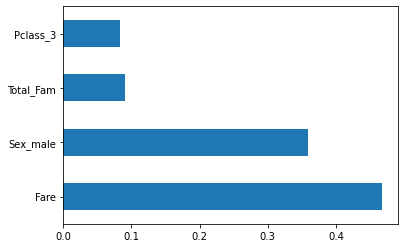

In [32]:
feat_importances = pd.Series(model.feature_importances_, index = X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

## Univariate Selection

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
bestfeatures= SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ["Specs","Score"]
featureScores.sort_values(by = ["Score"], ascending = False)

,Specs,Score
2,Fare,2013.106371
7,Sex_male,63.842384
6,Pclass_3,23.850678
14,Fare_bin_High,19.482398
3,CabinNull?,11.520494
1,Parch,3.936775
9,Embarked_S,3.326013
0,SibSp,3.123468
13,Fare_bin_Mid,2.334429
5,Pclass_2,2.229854


## Mutual Information

In [17]:
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(X_train,y_train)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)

In [18]:
mi_scores

Sex_male               0.160533
Fare                   0.096065
SibSp                  0.057623
CabinNull?             0.054442
Fare_bin_High          0.034852
Fare_bin_Mid           0.027355
Parch                  0.024394
Age_bin_Elderly        0.015179
Pclass_3               0.012878
Pclass_2               0.011514
Embarked_Q             0.005594
Total_Fam              0.000000
Embarked_S             0.000000
Age_bin_Adult          0.000000
Fare_bin_Low-to-Mid    0.000000
Name: MI Scores, dtype: float64

<Figure size 1200x1000 with 0 Axes>

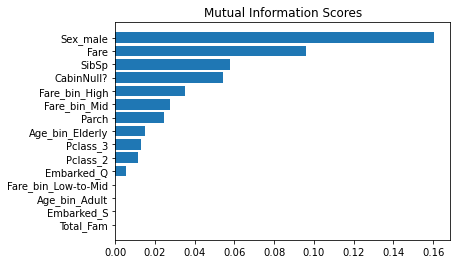

<Figure size 1200x1000 with 0 Axes>

In [21]:
scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(scores))
ticks = list(scores.index)
plt.barh(width, scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(12, 10))

I don't think that feature selection matters as much for the tree methods (decision and random forest) as they have feature selection embedded within it. That's why I didn't see much of a difference in accuracy when I did feature selection to when I didn't. I think that it will matter with other models.

## Model Selection

In [37]:
rfmodel = RandomForestClassifier()
admodel = AdaBoostClassifier()
knmodel = KNeighborsClassifier()
nbmodel = GaussianNB()
svmmodel = svm.SVC()
lrmodel = LogisticRegression()
ldamodel = LinearDiscriminantAnalysis()
pmodel = Perceptron()

In [39]:
from sklearn.model_selection import ShuffleSplit,cross_val_score
shuffle_split=ShuffleSplit(test_size=0.3,n_splits=1000)
scores=cross_val_score(rfmodel,X_train,y_train,cv=shuffle_split)
print("cross Validation scores:n {}".format(scores))
print("Average Cross Validation score :{}".format(scores.mean()))

cross Validation scores:n [0.79329609 0.82681564 0.82681564 0.79329609 0.75418994 0.77653631
 0.74301676 0.77653631 0.7877095  0.79329609 0.79888268 0.82122905
 0.80446927 0.82122905 0.81005587 0.74301676 0.7877095  0.76536313
 0.75418994 0.73743017 0.80446927 0.73184358 0.76536313 0.7877095
 0.78212291 0.83798883 0.82122905 0.79329609 0.81005587 0.73743017
 0.75418994 0.75977654 0.77653631 0.75977654 0.82681564 0.78212291
 0.77653631 0.81564246 0.82122905 0.74301676 0.7877095  0.82681564
 0.78212291 0.82122905 0.79888268 0.75418994 0.79888268 0.80446927
 0.81005587 0.76536313 0.75977654 0.81005587 0.75418994 0.7877095
 0.82122905 0.79888268 0.7877095  0.76536313 0.82681564 0.79329609
 0.7877095  0.79329609 0.74860335 0.74301676 0.82122905 0.81005587
 0.79888268 0.79329609 0.79888268 0.79888268 0.78212291 0.79888268
 0.77653631 0.75418994 0.76536313 0.79888268 0.75977654 0.74860335
 0.80446927 0.7877095  0.81564246 0.77653631 0.82681564 0.73743017
 0.74860335 0.7877095  0.80446927 0.82

In [40]:
from sklearn.model_selection import ShuffleSplit,cross_val_score
shuffle_split=ShuffleSplit(test_size=0.3,n_splits=1000)
scores=cross_val_score(admodel,X_train,y_train,cv=shuffle_split)
print("cross Validation scores:n {}".format(scores))
print("Average Cross Validation score :{}".format(scores.mean()))

cross Validation scores:n [0.82681564 0.77653631 0.78212291 0.79329609 0.82122905 0.76536313
 0.84357542 0.77653631 0.83240223 0.76536313 0.83240223 0.75418994
 0.82122905 0.7877095  0.83798883 0.73743017 0.75418994 0.79888268
 0.80446927 0.77094972 0.77094972 0.79329609 0.83798883 0.74301676
 0.82681564 0.79329609 0.76536313 0.73743017 0.84357542 0.79329609
 0.77653631 0.78212291 0.81005587 0.78212291 0.79329609 0.81564246
 0.79329609 0.75977654 0.76536313 0.84916201 0.84916201 0.82681564
 0.78212291 0.79329609 0.81005587 0.81564246 0.82122905 0.77653631
 0.75977654 0.79888268 0.75977654 0.7877095  0.80446927 0.7877095
 0.74860335 0.78212291 0.77094972 0.80446927 0.77094972 0.82122905
 0.81005587 0.74860335 0.7877095  0.78212291 0.79329609 0.79329609
 0.7877095  0.81005587 0.77094972 0.78212291 0.7877095  0.78212291
 0.81005587 0.81005587 0.83798883 0.81005587 0.81005587 0.75418994
 0.75418994 0.82681564 0.81005587 0.83798883 0.81005587 0.74860335
 0.83798883 0.78212291 0.81564246 0.8

In [41]:
from sklearn.model_selection import ShuffleSplit,cross_val_score
shuffle_split=ShuffleSplit(test_size=0.3,n_splits=1000)
scores=cross_val_score(knmodel,X_train,y_train,cv=shuffle_split)
print("cross Validation scores:n {}".format(scores))
print("Average Cross Validation score :{}".format(scores.mean()))

cross Validation scores:n [0.68715084 0.70391061 0.72067039 0.69273743 0.68715084 0.73184358
 0.72067039 0.77094972 0.72625698 0.74860335 0.75977654 0.67039106
 0.74301676 0.70949721 0.77094972 0.73184358 0.69832402 0.73743017
 0.70949721 0.69832402 0.73743017 0.73743017 0.74301676 0.74860335
 0.7877095  0.74301676 0.70949721 0.74860335 0.70949721 0.79888268
 0.76536313 0.70391061 0.68156425 0.68715084 0.76536313 0.72067039
 0.79329609 0.70949721 0.73743017 0.74301676 0.72067039 0.73184358
 0.73184358 0.7150838  0.72625698 0.73184358 0.70391061 0.77653631
 0.76536313 0.74860335 0.78212291 0.70949721 0.73184358 0.73184358
 0.75418994 0.81564246 0.74860335 0.75977654 0.75418994 0.70949721
 0.74860335 0.72067039 0.73184358 0.74301676 0.74301676 0.7150838
 0.76536313 0.75418994 0.74301676 0.74860335 0.74301676 0.7150838
 0.74860335 0.72067039 0.73743017 0.7150838  0.77094972 0.70391061
 0.6424581  0.77653631 0.72067039 0.72625698 0.7150838  0.79888268
 0.73743017 0.77653631 0.70391061 0.72

In [42]:
from sklearn.model_selection import ShuffleSplit,cross_val_score
shuffle_split=ShuffleSplit(test_size=0.3,n_splits=1000)
scores=cross_val_score(nbmodel,X_train,y_train,cv=shuffle_split)
print("cross Validation scores:n {}".format(scores))
print("Average Cross Validation score :{}".format(scores.mean()))

cross Validation scores:n [0.74301676 0.75977654 0.77094972 0.50837989 0.70949721 0.72625698
 0.74860335 0.73184358 0.77094972 0.54189944 0.77653631 0.75418994
 0.74860335 0.74301676 0.75977654 0.75977654 0.74301676 0.73743017
 0.75977654 0.74301676 0.72067039 0.73184358 0.51396648 0.74860335
 0.79329609 0.78212291 0.44134078 0.75977654 0.54748603 0.78212291
 0.75977654 0.75977654 0.74301676 0.72625698 0.79888268 0.74860335
 0.72625698 0.75418994 0.7150838  0.46368715 0.74860335 0.72625698
 0.75977654 0.74301676 0.73184358 0.75418994 0.73184358 0.74301676
 0.81005587 0.72067039 0.74860335 0.81005587 0.76536313 0.80446927
 0.74860335 0.73743017 0.75418994 0.79888268 0.78212291 0.73743017
 0.73743017 0.74860335 0.77653631 0.44134078 0.74301676 0.48603352
 0.57541899 0.77653631 0.78212291 0.78212291 0.51396648 0.73184358
 0.73743017 0.75418994 0.56424581 0.73184358 0.63128492 0.73184358
 0.79329609 0.79888268 0.40223464 0.76536313 0.77094972 0.81564246
 0.45810056 0.5698324  0.53631285 0.

In [43]:
from sklearn.model_selection import ShuffleSplit,cross_val_score
shuffle_split=ShuffleSplit(test_size=0.3,n_splits=1000)
scores=cross_val_score(svmmodel,X_train,y_train,cv=shuffle_split)
print("cross Validation scores:n {}".format(scores))
print("Average Cross Validation score :{}".format(scores.mean()))

cross Validation scores:n [0.59217877 0.67039106 0.68156425 0.65363128 0.66480447 0.70391061
 0.64804469 0.6424581  0.67039106 0.64804469 0.66480447 0.67597765
 0.69273743 0.64804469 0.70391061 0.6424581  0.63128492 0.66480447
 0.64804469 0.65363128 0.67039106 0.69273743 0.63128492 0.65921788
 0.65921788 0.66480447 0.67597765 0.68156425 0.63128492 0.67039106
 0.72625698 0.62011173 0.64804469 0.66480447 0.70949721 0.63687151
 0.66480447 0.67039106 0.68715084 0.67597765 0.70949721 0.65921788
 0.58100559 0.6424581  0.67597765 0.61452514 0.65921788 0.6424581
 0.72067039 0.70949721 0.65363128 0.65363128 0.69273743 0.68715084
 0.67039106 0.66480447 0.66480447 0.63687151 0.70949721 0.66480447
 0.63128492 0.6424581  0.68715084 0.62011173 0.69832402 0.67039106
 0.72067039 0.67039106 0.65363128 0.6424581  0.72067039 0.65921788
 0.68715084 0.64804469 0.63687151 0.6424581  0.72067039 0.67039106
 0.66480447 0.69273743 0.69832402 0.67597765 0.63687151 0.64804469
 0.64804469 0.68156425 0.69832402 0.6

In [44]:
from sklearn.model_selection import ShuffleSplit,cross_val_score
shuffle_split=ShuffleSplit(test_size=0.3,n_splits=1000)
scores=cross_val_score(lrmodel,X_train,y_train,cv=shuffle_split)
print("cross Validation scores:n {}".format(scores))
print("Average Cross Validation score :{}".format(scores.mean()))

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

cross Validation scores:n [0.84916201 0.79888268 0.77094972 0.78212291 0.80446927 0.79329609
 0.82122905 0.75418994 0.81564246 0.83798883 0.77653631 0.79888268
 0.81005587 0.79329609 0.81005587 0.78212291 0.76536313 0.75977654
 0.81005587 0.76536313 0.76536313 0.79888268 0.82122905 0.77653631
 0.81005587 0.79329609 0.82681564 0.78212291 0.77653631 0.78212291
 0.79329609 0.75977654 0.83798883 0.77094972 0.82681564 0.76536313
 0.79888268 0.81005587 0.76536313 0.73184358 0.80446927 0.82122905
 0.77653631 0.79888268 0.79888268 0.79888268 0.76536313 0.81005587
 0.82681564 0.83240223 0.78212291 0.81005587 0.77094972 0.80446927
 0.83240223 0.80446927 0.78212291 0.81564246 0.83798883 0.81005587
 0.77094972 0.75977654 0.78212291 0.8603352  0.77094972 0.81564246
 0.77653631 0.7877095  0.82122905 0.83798883 0.80446927 0.84357542
 0.79888268 0.76536313 0.77094972 0.79888268 0.77094972 0.84357542
 0.79329609 0.79329609 0.81005587 0.76536313 0.79329609 0.77094972
 0.83798883 0.80446927 0.78212291 0.

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\z004hfjb\Anaconda3\lib\site

In [45]:
from sklearn.model_selection import ShuffleSplit,cross_val_score
shuffle_split=ShuffleSplit(test_size=0.3,n_splits=1000)
scores=cross_val_score(ldamodel,X_train,y_train,cv=shuffle_split)
print("cross Validation scores:n {}".format(scores))
print("Average Cross Validation score :{}".format(scores.mean()))

cross Validation scores:n [0.75418994 0.81005587 0.82122905 0.81564246 0.79329609 0.77653631
 0.79329609 0.75418994 0.82681564 0.82681564 0.77653631 0.80446927
 0.75977654 0.77653631 0.83798883 0.77094972 0.77653631 0.81005587
 0.76536313 0.82122905 0.78212291 0.77094972 0.83798883 0.81564246
 0.84916201 0.81564246 0.84916201 0.82122905 0.79329609 0.84916201
 0.75977654 0.81005587 0.81564246 0.79329609 0.83240223 0.75418994
 0.77653631 0.81005587 0.79329609 0.81564246 0.81564246 0.77653631
 0.84916201 0.81005587 0.76536313 0.81005587 0.7877095  0.81564246
 0.79888268 0.79329609 0.79888268 0.7877095  0.83240223 0.81564246
 0.8547486  0.78212291 0.79888268 0.76536313 0.78212291 0.78212291
 0.79329609 0.79329609 0.77094972 0.82122905 0.82681564 0.82681564
 0.77653631 0.77094972 0.79888268 0.77094972 0.81005587 0.84916201
 0.78212291 0.78212291 0.81564246 0.83240223 0.79888268 0.78212291
 0.79888268 0.80446927 0.8547486  0.80446927 0.81005587 0.7877095
 0.80446927 0.77653631 0.82122905 0.8

In [46]:
from sklearn.model_selection import ShuffleSplit,cross_val_score
shuffle_split=ShuffleSplit(test_size=0.3,n_splits=1000)
scores=cross_val_score(pmodel,X_train,y_train,cv=shuffle_split)
print("cross Validation scores:n {}".format(scores))
print("Average Cross Validation score :{}".format(scores.mean()))

cross Validation scores:n [0.59776536 0.61452514 0.68715084 0.74860335 0.62011173 0.70391061
 0.72625698 0.75977654 0.74860335 0.61452514 0.68715084 0.60893855
 0.84916201 0.6424581  0.59776536 0.58100559 0.62569832 0.58100559
 0.67597765 0.67039106 0.68715084 0.62569832 0.77094972 0.39664804
 0.64804469 0.70391061 0.63687151 0.67039106 0.63687151 0.60893855
 0.73743017 0.75418994 0.6424581  0.78212291 0.77653631 0.77653631
 0.63128492 0.59776536 0.75418994 0.70949721 0.64804469 0.69273743
 0.65921788 0.69832402 0.60335196 0.65363128 0.74860335 0.42458101
 0.7150838  0.54748603 0.36871508 0.59776536 0.36871508 0.62569832
 0.46368715 0.75418994 0.41899441 0.63128492 0.6424581  0.68156425
 0.65921788 0.55865922 0.61452514 0.69832402 0.59217877 0.62569832
 0.33519553 0.70949721 0.70391061 0.73743017 0.72625698 0.75977654
 0.76536313 0.61452514 0.68715084 0.69832402 0.64804469 0.62011173
 0.67597765 0.72067039 0.60335196 0.74301676 0.75977654 0.6424581
 0.74860335 0.77653631 0.69273743 0.7

Best ones that I noticed where Random Forest, Decision Tree, Adaboost, and LinearDiscriminantAnalysis